In [1]:
import gym
import numpy as np

## BlackJack 환경 정의

In [2]:
env = gym.make('Blackjack-v0') # Blackjack 환경 이름

print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


- States  
  env.observation_space[0]: (어떤 카드인지는 모르나, 받은 카드들의 합이) 0~31 사이의 값이 나올 수 있다.

  env.observation_space[1]: 딜러의 경우 0~10까지의 값을 가질 수 있음. (showing card)

  env.observation_space[2]: usable ace가 있는지 없는지 (1: 있다, 0: 없다)

- Actions

  action_space: stick? hit?

In [3]:
for i in range(10): # 10판 
  state = env.reset() # 초기값 받아오기 
  while True:
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action) # action을 수행 
    print(state, action, reward, next_state)

    if done:
      print('done')
      break

    state = next_state
  print('---')

(15, 6, False) 0 1.0 (15, 6, False)
done
---
(20, 1, False) 0 1.0 (20, 1, False)
done
---
(14, 10, False) 1 -1.0 (24, 10, False)
done
---
(12, 7, False) 1 -1.0 (22, 7, False)
done
---
(11, 10, False) 1 0.0 (16, 10, False)
(16, 10, False) 0 -1.0 (16, 10, False)
done
---
(14, 1, False) 0 -1.0 (14, 1, False)
done
---
(10, 3, False) 1 0.0 (13, 3, False)
(13, 3, False) 0 -1.0 (13, 3, False)
done
---
(18, 9, False) 1 -1.0 (22, 9, False)
done
---
(14, 9, False) 1 -1.0 (24, 9, False)
done
---
(11, 7, False) 0 1.0 (11, 7, False)
done
---


## Visualization

In [12]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
import pandas as pd
from collections import namedtuple
from collections import defaultdict
import random
%matplotlib inline

def plot_value_function(V, title = 'Value Function'):
  '''
  Value function을 surface plot으로 그리기
  '''
  min_x = 11
  max_x = max(k[0] for k in V.keys())
  min_y = min(k[1] for k in V.keys())
  max_y = max(k[1] for k in V.keys())

  x_range = np.arange(min_x, max_x+1)
  y_range = np.arange(min_y, max_y+1)
  X, Y = np.meshgrid(x_range, y_range)

  # 모든 (x,y) 좌표에 대해 값 찾기
  Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X,Y]))
  Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X,Y]))

  def plot_surface(X, Y, Z, title):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Player Sum')
    ax.set_ylabel('Dealer Showing')
    ax.set_zlabel('Value')
    ax.set_title(title)
    ax.view_init(ax.elev, -120)
    fig.colorbar(surf)
    plt.show()

  plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
  plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

## Policy 정의

'과연 Policy에 따라 승패가 차이가 날까?'

In [5]:
def random_policy(observation):
  return env.action_space.sample()

def hit_only_policy(observation):
  if observation[0] == 21:
    return 0
  return 1

def stick_only_policy(observation):
  return 0

# Player의 score가 16 이상이면 stick하고 그렇지 않으면 hit하는 policy
def fixed_policy(observation):
  score, dealer_score, usable_ace = observation
  return 0 if score>=16 else 1

## 게임 플레이

In [6]:
def play_game(policy, env):
  nWon = 0
  nLost = 0
  nDraw = 0
  policy = policy

  for i in range(100000):
    observation = env.reset()
    while True:
      action = policy(observation)

      next_observation, reward, done, _ = env.step(action) 
      if done:

        if reward == 1:
          nWon += 1
        elif reward == -1:
          nLost += 1
        else:
          nDraw += 1
        break

      observation = next_observation

  print(nWon, nLost, nDraw)

In [7]:
play_game(random_policy, env)
play_game(hit_only_policy, env)
play_game(stick_only_policy, env)
play_game(fixed_policy, env) # Policy가 좋으면 승률이 높아짐. 

28259 67417 4324
15652 82194 2154
37909 56838 5253
41482 48786 9732


cf. 블랙잭은 무슨 수를 쓰더라도, 확률적으로 딜러가 더 유리한 게임!

# Monte Carlo를 사용한 BlackJack 게임

In [10]:
def mc_prediction(policy, env, num_episodes, alpha=0.01, gamma=0.99):

  N = defaultdict(float) # 각 State의 출현 횟수
  V = defaultdict(float) # 각 State의 Value

  for i_episode in range(num_episodes): 

    state = env.reset()
    trajectory = []

    while True:
      action = policy(state)
      next_state, reward, done, _ = env.step(action)

      trajectory.append((state, action, reward))

      if done:
        break

      state = next_state

    states, actions, rewards = zip(*trajectory)
    discounts = np.array([gamma**i for i in range(len(rewards))])

    for i, s in enumerate(states): # Every-Visit MC Version

      N[s] += 1
      G = sum(rewards[i:] * discounts[:len(rewards)-i])

      V[s] = V[s] + 1/N[s] * (G-V[s])

  return V

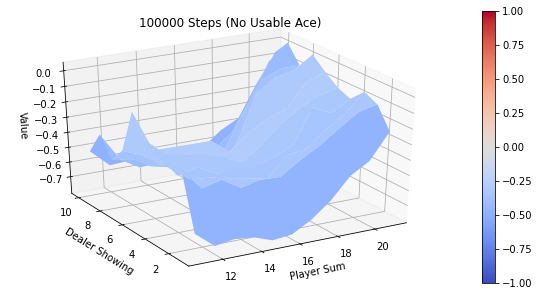

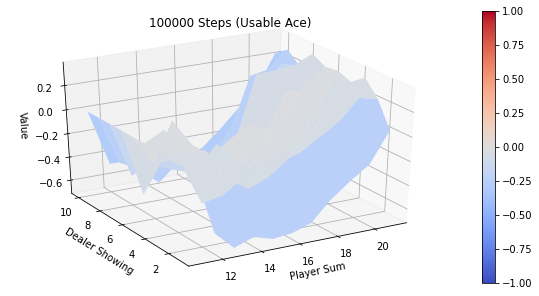

In [13]:
V_random = mc_prediction(random_policy, env, num_episodes = 100000)
plot_value_function(V_random, title='100000 Steps')

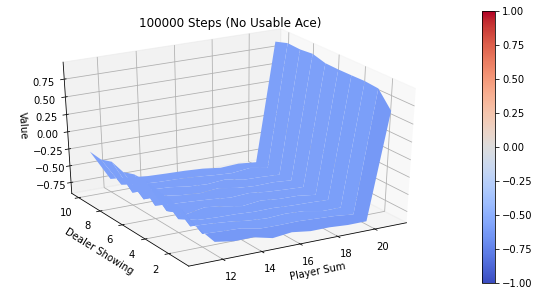

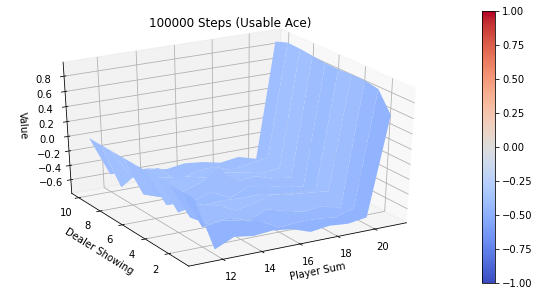

In [14]:
V_hit_only = mc_prediction(hit_only_policy, env, num_episodes = 100000)
plot_value_function(V_hit_only, title='100000 Steps')

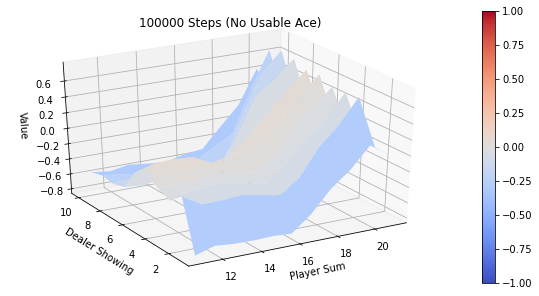

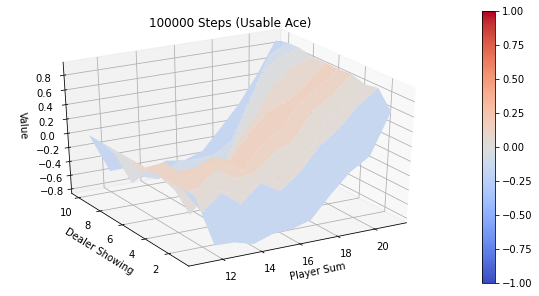

In [15]:
V_stick_only = mc_prediction(stick_only_policy, env, num_episodes=100000)
plot_value_function(V_stick_only, title='100000 Steps')

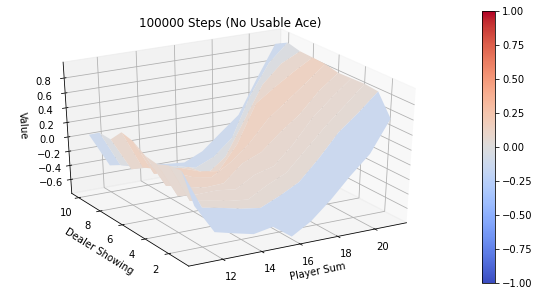

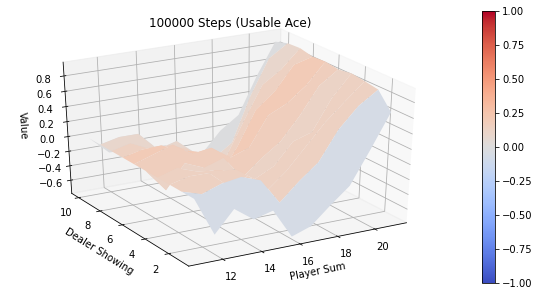

In [16]:
V_fixed = mc_prediction(fixed_policy, env, num_episodes=100000)
plot_value_function(V_fixed, title='100000 Steps')

# TD Learning을 사용한 BlackJack 게임

In [17]:
def td_prediction(policy, env, num_episodes, alpha=0.01, gamma=0.99):

  N = defaultdict(float) # 각 State의 출현 횟수
  V = defaultdict(float) # 각 State의 Value

  for i_episode in range(num_episodes): 

    state = env.reset()
    trajectory = []

    while True:
      action = policy(state)
      next_state, reward, done, _ = env.step(action)

      trajectory.append((state, action, reward))

      if done:
        break

      state = next_state

    states, actions, rewards = zip(*trajectory)
    discounts = np.array([gamma**i for i in range(2)])

    for i, s in enumerate(states):

      N[s] += 1
      td_target = sum(rewards[i:i+2] * discounts)

      V[s] = V[s] + 1/N[s] * (td_target-V[s])

  return V

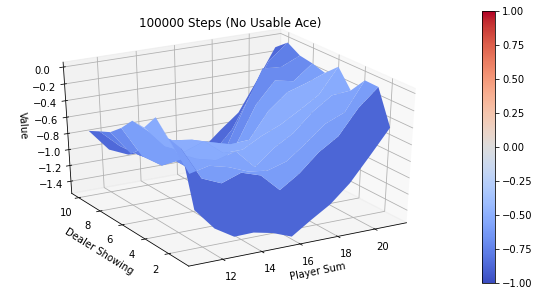

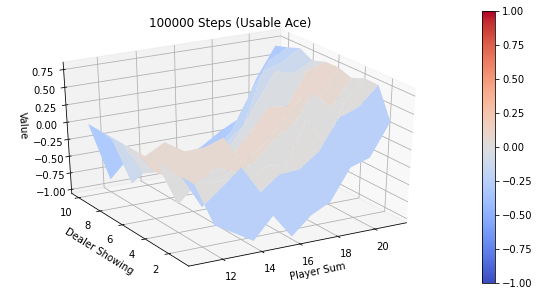

In [18]:
V_random = td_prediction(random_policy, env, num_episodes = 100000)
plot_value_function(V_random, title='100000 Steps')

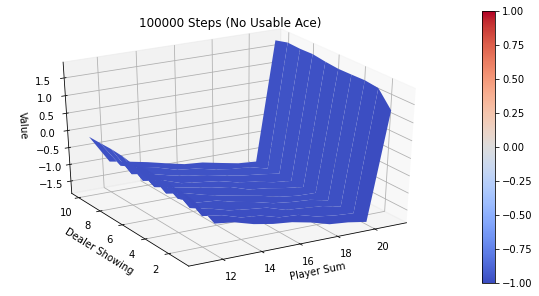

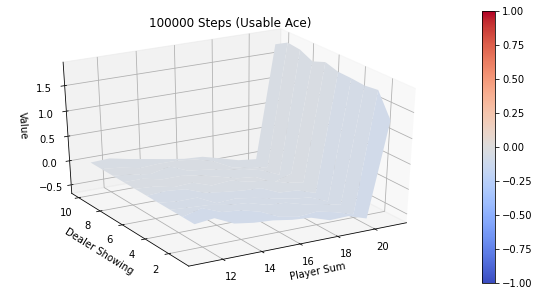

In [20]:
V_hit_only = td_prediction(hit_only_policy, env, num_episodes = 100000)
plot_value_function(V_hit_only, title='100000 Steps')

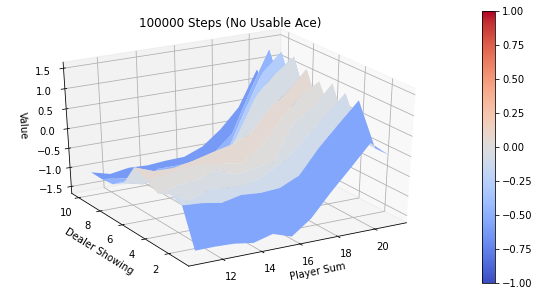

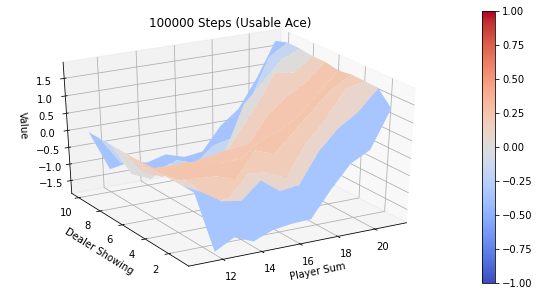

In [21]:
V_stick_only = td_prediction(stick_only_policy, env, num_episodes=100000)
plot_value_function(V_stick_only, title='100000 Steps')

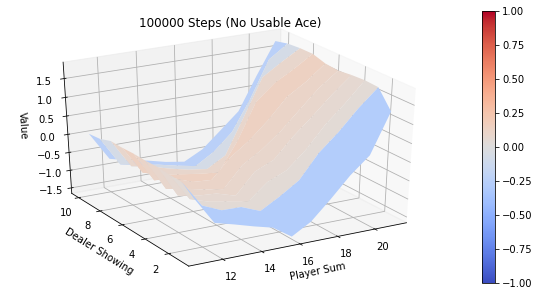

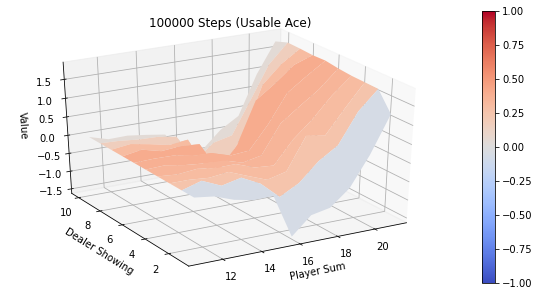

In [22]:
V_fixed = td_prediction(fixed_policy, env, num_episodes=100000)
plot_value_function(V_fixed, title='100000 Steps')